In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
scooters_info = pd.read_csv('scooters_with_density.csv')
scooters_info.head(5)

,scooter_id,xcoordinate,ycoordinate,power_level,density,avg_power_lv,charging_time
0,0,0.906835,0.776484,0,1371,2.453683,5
1,1,0.928587,0.804964,2,1314,2.454338,3
2,2,0.904091,0.784043,1,1335,2.456929,4
3,3,0.906752,0.804461,0,1314,2.459665,5
4,4,0.900641,0.781683,4,1323,2.458806,1


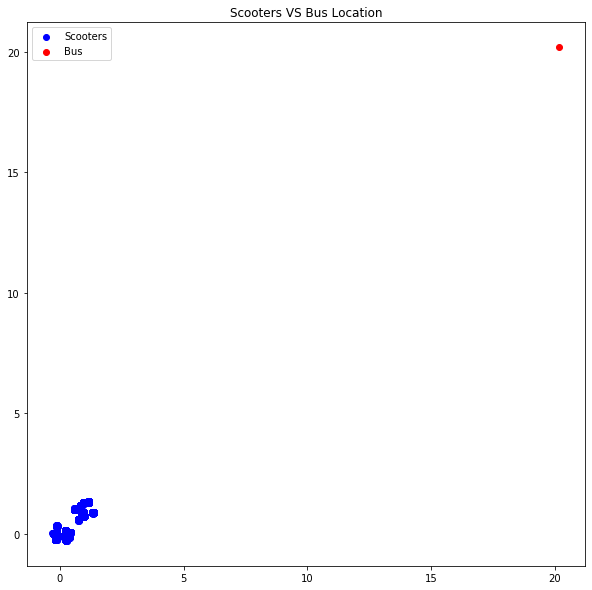

In [3]:
def plot_bus_location(bus_coordinates, plot_size = (10, 10)): 
    plt.figure(figsize = plot_size)

    #plot the scooters' locations:
    plt.scatter(scooters_info['xcoordinate'], scooters_info['ycoordinate'], color = 'blue')
    
    #plot the bus' location:
    plt.scatter(bus_coordinates[0], bus_coordinates[1], color = 'red')

    plt.title("Scooters VS Bus Location")

    plt.legend(["Scooters", "Bus"])
    
plot_bus_location(bus_coordinates = (20.19, 20.19))

In [4]:
def update_distance_to_bus(bus_coordinates):
    bus_x = bus_coordinates[0]
    bus_y = bus_coordinates[1]
    
    scooters_info['distance_to_bus'] = (bus_x - scooters_info.xcoordinate)**2 + (bus_y - scooters_info.ycoordinate)**2
    scooters_info['distance_to_bus'] = (scooters_info['distance_to_bus'])**(1/2) #take square root 
    
update_distance_to_bus((20.19, 20.19))
scooters_info.sort_values('distance_to_bus', ascending = False).head()

,scooter_id,xcoordinate,ycoordinate,power_level,density,avg_power_lv,charging_time,distance_to_bus
14264,14264,-0.187324,-0.235290,3,975,2.491282,2,28.851825
13850,13850,-0.172924,-0.248547,3,977,2.496418,2,28.851046
14412,14412,-0.182049,-0.238552,2,981,2.492355,3,28.850409
14235,14235,-0.173875,-0.246558,5,980,2.496939,0,28.850309
13887,13887,-0.164171,-0.255281,2,940,2.482979,3,28.849641


In [5]:
print("MAX average power level:", scooters_info.iloc[scooters_info.avg_power_lv.idxmax(), 5])

print("\nMIN average power level:", scooters_info.iloc[scooters_info.avg_power_lv.idxmin(), 5])

MAX average power level: 2.550669216061185

MIN average power level: 2.3989266547406083


###### Comment: 
There is not much difference between the min and max of the average power level, which is the mean of the power level of all the scooters within the specified scooter's radius. In other words, there is no particular area that requires immediate "rescue". Therefore, not too much attention should be paid to this factor when deciding our journey.

***********

#### The task of charging can be divided into 2 subtasks: 
1. Pick up scooters with power level less than 5
2. Drop off fully-charged scooters

In [6]:
#choose low-power scooters in low-density areas first (to avoid disrupting customers' experience):
pick_up_order = scooters_info.sort_values(['power_level', 'density'], ascending = True).copy()

#surely, a zero-power scooter should be picked up before a three-power scooter (sort by power_level first)

#but for two three-power scooters, the one with higher density should be picked up later
#>because there's a higher chance of it being used by someone (sort by density)

In [7]:
#because for power_level of 0 and 1, the density doesn't matter > sort by distance_to_bus instead. 
#based on how the scooters are located, scooters near to the bus are also relatively near to each other, 
#so we don't have to go back and forth:

zero_and_one = scooters_info.loc[scooters_info.power_level.isin([0,1])].copy() #scooters with power level of 0 and 1
zero_and_one.sort_values(['power_level', 'distance_to_bus'], ascending = True, inplace = True)

bw_2_and_4 = pick_up_order.loc[~pick_up_order.power_level.isin([0,1,5])].copy() 
#scooters with neither zero nor one nor full power

pick_up_order = pd.concat([zero_and_one, bw_2_and_4]) #put 'zero_and_one' on top of 'bw_2_and_4'

pick_up_order.head(5)

,scooter_id,xcoordinate,ycoordinate,power_level,density,avg_power_lv,charging_time,distance_to_bus
3434,3434,1.174540,1.349940,0,910,2.494505,5,26.768182
3033,3033,1.184990,1.333143,0,911,2.492865,5,26.772588
3105,3105,1.175928,1.341352,0,913,2.491785,5,26.773242
3447,3447,1.169269,1.346719,0,914,2.489059,5,26.774194
2748,2748,1.190299,1.325479,0,908,2.488987,5,26.774219


In [8]:
drop_off_order = scooters_info.sort_values(['density'], ascending = False).copy()

#we want to pick up at high-density lastly but drop off at high-density first

print("Last pick up scooter_id:", pick_up_order.iloc[-1, 0])
print("First drop off scooter_id:", drop_off_order.iloc[0, 0])

Last pick up scooter_id: 1070
First drop off scooter_id: 1070


###### COMMENT: 
If we just sort by density, it ends up that we only start dropping off after having picked up everything. This is certainly not wanted. We need to drop off as we go because the bus's capacity is limited and we want to make the best use of it. However, we still want to prioritize high-density places when dropping off.  

###### DROP OFF SUGGESTION:

There will be 2 drop-off options:
1. If the number of fully charged scooters is below the drop-off limit >>> (Wait to) Drop off at pick-up points that have high density
2. If the number of fully charged scooters exceeds the drop-off limit (in other words, the cost of waiting for the next high-density point is higher than its benefit) >>> Find a nearby point with max density and drop off there (See max_density_near_bus)

For example, assume that the drop-off limit is 10 fully-charged scooters. If the bus arrives at a pick-up point that is labelled "high density" and currently has only 3 fully-charged scooters, it will still drop off all the fully-charged there. If the bus arrives at a pick-up point that is labelled "low density" but currently has 11 fully-charged scooters, it will find a nearby point with max density by calling max_density_near_bus() and drop the scooters off at that location.

In [9]:
def label_density_level(hi_density_threshold): #label a pick_up point as high density or low density
    max_density = pick_up_order.density.max()
    
    try:
        pick_up_order['density_level'] = pd.cut(pick_up_order.density, 
                                                bins = [0, hi_density_threshold, max_density], 
                                                labels= ['low density', 'high density'])
    
    except ValueError:
        print('ERROR: hi_density_threshold is greater than max_density')
    
label_density_level(hi_density_threshold = 1700)
#if density is greater than 1700, label the point as high density. If not, low density

pick_up_order.head(5)

,scooter_id,xcoordinate,ycoordinate,power_level,density,avg_power_lv,charging_time,distance_to_bus,density_level
3434,3434,1.174540,1.349940,0,910,2.494505,5,26.768182,low density
3033,3033,1.184990,1.333143,0,911,2.492865,5,26.772588,low density
3105,3105,1.175928,1.341352,0,913,2.491785,5,26.773242,low density
3447,3447,1.169269,1.346719,0,914,2.489059,5,26.774194,low density
2748,2748,1.190299,1.325479,0,908,2.488987,5,26.774219,low density


In [10]:
def max_density_near_bus(bus_coordinates, radius): 
    #return the coordinates of the scooter(point) near the bus with the highest density
    
    update_distance_to_bus(bus_coordinates)
    
    scooters_near_bus = scooters_info.loc[scooters_info.distance_to_bus < radius].copy()
    #scooters within the bus's radius
    
    scooters_near_bus.sort_values(['density', 'distance_to_bus'], ascending = [False, True], inplace = True)
    #scooters with highest density and closest to the bus will be on top
    
    scooters_near_bus.reset_index(inplace = True)
    
    try:
        nearest_max_density_scooter = scooters_near_bus.iloc[0]
        return tuple([nearest_max_density_scooter.xcoordinate, nearest_max_density_scooter.ycoordinate])
    
    except IndexError: #if scooters_near_bus is empty
        print("No scooter nearby")

max_density_near_bus((1.174540, 1.349940), 0.05)

(1.17135302, 1.346357779)

******************************

After having arrived at the final pick-up location and dropping off all the fully-charged, the bus will still have some remaining scooters. At this point, make an update of the average power level (avg_power_level): 
1. If there exists a particular area with low avg_power_level, drop the scooters (once they're fully charged) there. This can be because the area is randomly "neglected" or the demand (for scooters) in that area suddenly rises. We also need to make this area our first priority of dropping off scooters in the next (repeated) process.   
2. If there's not much difference among the areas, simply repeat the process.   